# Using the low-level API from HSSM directly with PyMC

This is a tutorial for advanced users who prefer to use the convenience functions and classes in HSSM to create models and sample in PyMC without using `bambi`. We assume that the readers of this tutorial are familiar with the internals of `PyMC`, `pytensor`, and/or `JAX`.

In addition to the high-level API that relies on `bambi` for model creation, HSSM also features a low-level API that it internally calls for creating `pytensor` `Op`s and `pm.Distribution`s. Experienced users can use the low-level API directly with `PyMC` to create even more customized models. This tutorial shows how advanced users can utilize the low-level API and convenience functions that HSSM provides to interface with PyMC.

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://github.com/lnccbrown/HSSM/blob/main/docs/tutorials/pymc.ipynb). 

Once you are *in the colab*, follow the *installation instructions below* and then **restart your runtime**. 

Just **uncomment the code in the next code cell** and run it!

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.

Note that if you switch your runtime you have to follow the installation instructions again.

In [1]:
# If running this on Colab, please uncomment the next line
# !pip install hssm

## Load Modules

In [2]:
import arviz as az
import pymc as pm
from matplotlib import pyplot as plt

import hssm

hssm.set_floatX("float32")

Setting PyTensor floatX type to float32.
Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


## Build a model directly from PyMC

With `DDM` and `DDM_SDV` which are `pm.Distribution`s, we can create models directly with PyMC. We first simulate some data using `ssm_simulators` and then use `PyMC` to specify the model and sample from the it.

In [3]:
# Simulate some data
v_true, a_true, z_true, t_true, sv_true = [0.5, 1.5, 0.5, 0.5, 0.1]
dataset = hssm.simulate_data(
    model="ddm_sdv",
    theta=[v_true, a_true, z_true, t_true, sv_true],
    size=1000,
)

dataset

,rt,response
0,8.299633,1.0
1,1.350374,1.0
2,1.315660,1.0
3,2.808372,1.0
4,2.773419,1.0
...,...,...
995,5.265402,-1.0
996,1.406551,-1.0
997,5.977109,1.0
998,2.469182,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, a, z, t]


Output()

Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 90 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


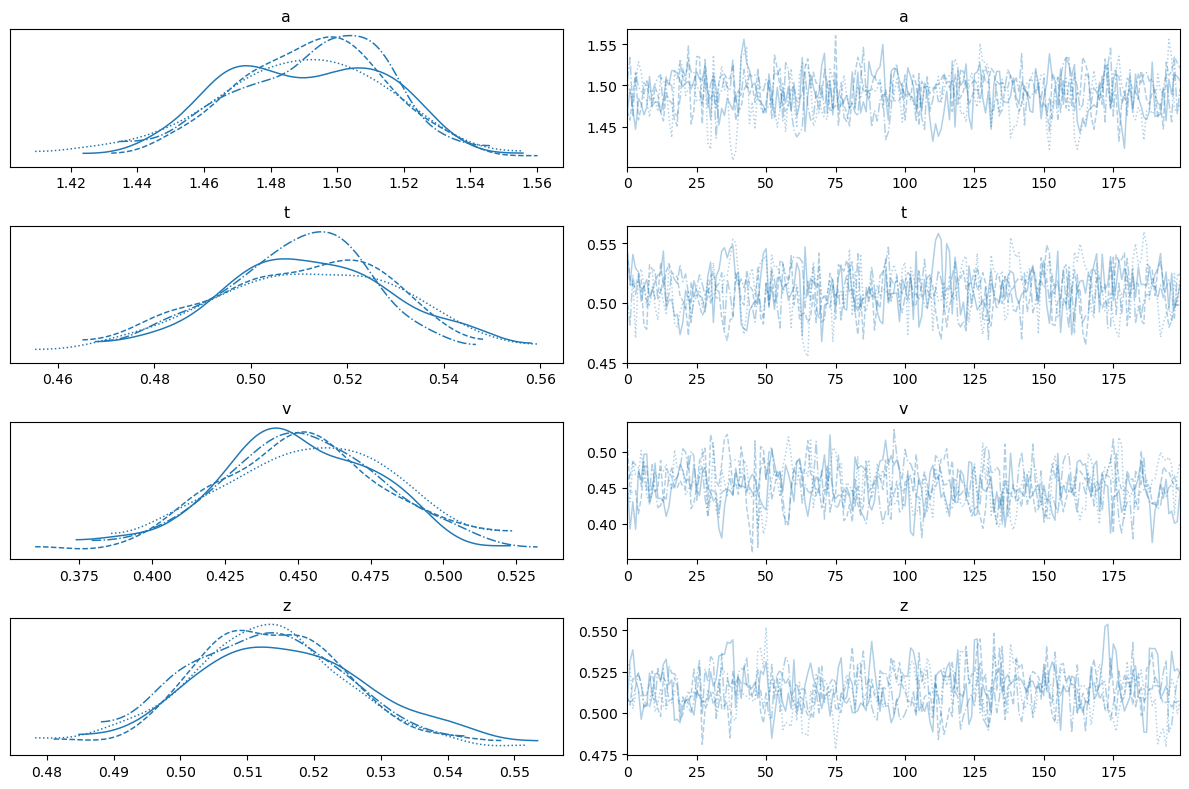

In [4]:
# This is a pm.Distribution available in HSSM
# There is also a DDM_SDV class for DDMs with the sv parameter
from hssm.likelihoods import DDM

with pm.Model() as ddm_pymc:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)

    ddm = DDM("ddm", v=v, a=a, z=z, t=t, observed=dataset.values)

    ddm_pymc_trace = pm.sample(mp_ctx="spawn", tune=200, draws=200)

az.plot_trace(ddm_pymc_trace)
plt.tight_layout()

## Building custom top-level distributions with `make_distribution`

**Note**: This tutorial has undergone major updates in HSSM 0.2.1+ following breaking changes in the `distribution_utils` api. Please follow this tutorial closely if your previous code no longer works.

### `make_distribution`

The above example shows that, as long as the top-level distribution is known, modeling can be done in `PyMC` as well without using `Bambi`. However, as [this official `PyMC` tutorial](https://www.pymc.io/projects/docs/en/latest/contributing/implementing_distribution.html) shows, creating a distribution in PyMC can be a time consuming-task. You will need to create a `RandomVariable` first and then define your custom `Distribution` by extending `pm.Distribution` class. From `PyMC 5.0.0` on, `pm.CustomDist` simplifies this process, but the use case is not applicable to complex likelihoods in HSSM. Therefore, HSSM provides convenience functions in its `distribution_utils` submodule that make this process easy. Next, we use another example to show how we can use these functions to create custom `pm.Distribution`s to be used with `PyMC`.

**Use Case**: Suppose we have a likelihood function for DDM models with standard deviations for `v` written. This model has 5 parameters: `v, a, z, t, sv`, and we want to use this function as the likelihood to create a `pm.Distribution` for modeling with `PyMC`. We can use `make_distribution` for this purpose.

**Note**: 
This distribution is already available in HSSM at `hssm.likelihoods.DDM_SDV`. For illustration purposes, we go through the same process in which this distribution is created. We can use the same procedure for other distributions not currently available in HSSM.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, a, z, t, sv]


Output()

Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 88 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


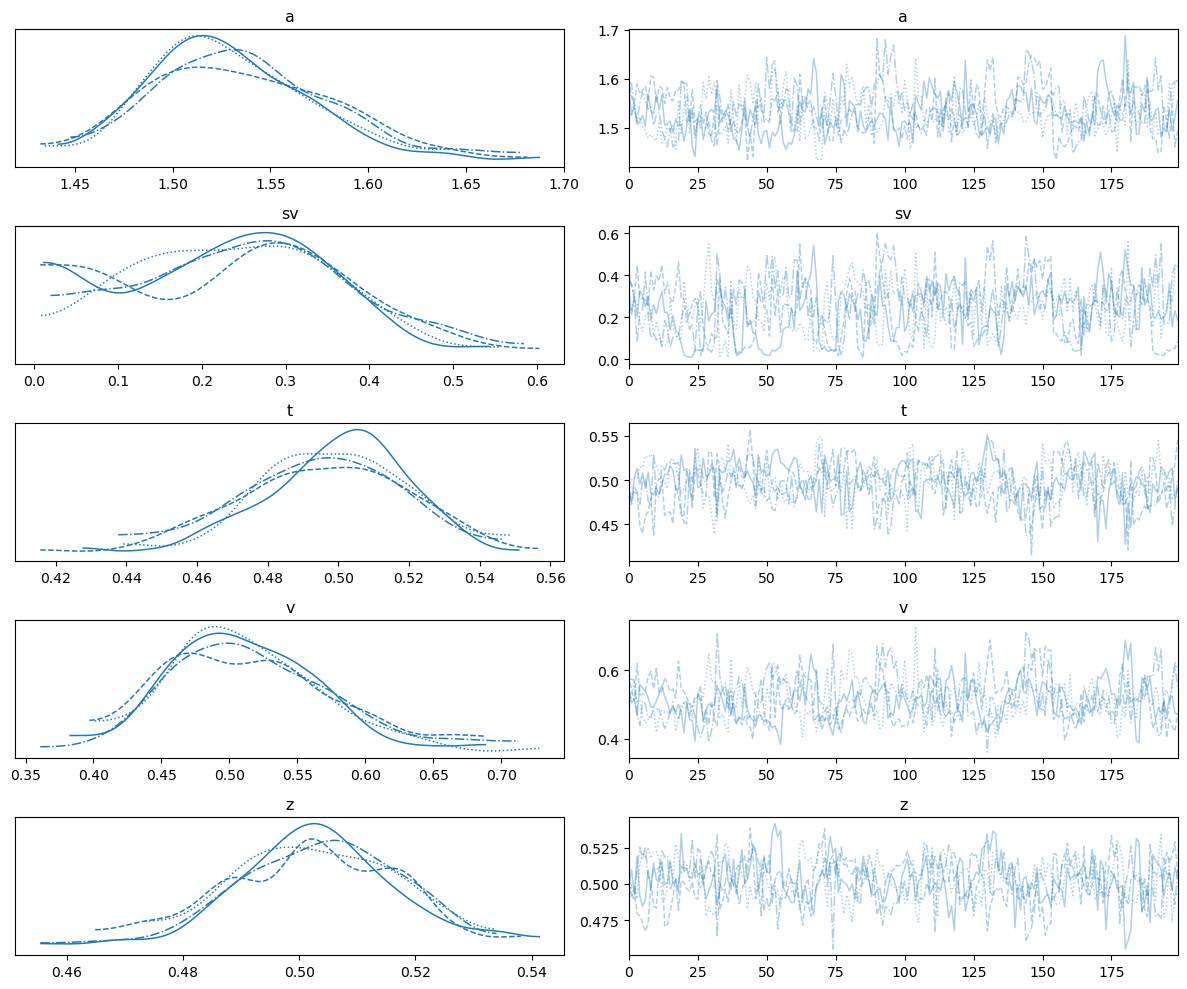

In [5]:
# This is a likelihood function for the DDM with SDV
# Different from DDM which we imported in the previous example,
# which is a pm.Distribution
from hssm.distribution_utils import make_distribution
from hssm.likelihoods import logp_ddm_sdv

# We use `make_distribution` to wrap the likelihood function into a pm.Distribution
DDM_SDV = make_distribution(
    rv="ddm_sdv",
    loglik=logp_ddm_sdv,
    list_params=["v", "a", "z", "t", "sv"],
    bounds={"t": (0, 1)},
)

with pm.Model() as ddm_sdv_model:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)
    sv = pm.HalfNormal("sv", sigma=2.0)

    ddm = DDM_SDV("ddm", v=v, a=a, z=z, t=t, sv=sv, observed=dataset.values)

    ddm_sdv_trace = pm.sample(mp_ctx="spawn", tune=200, draws=200)

az.plot_trace(ddm_sdv_trace)
plt.tight_layout()

The above example shows how to use the `make_distribution` factory function to create a `pm.Distribution` class that can be used for modeling in `PyMC` in the code above. All you need is a likelihood function that can be directly used with `pytensor`. This mostly is a Python function written in `pytensor`, as is the case with `logp_ddm_sdv`. If you have a likelihood function written with JAX or Cython, or if you have an approximate differentiable likelihood saved in an `onnx` file, you need to wrap this likelihood in a pytensor `Op` before using the `make_distribution` function. The next section describes how to do so. Please refer to the next section to create a `pytensor`-compatible likelihood function before coming back to this section to create a `PyMC` `Distribution` class.

Detailed usage of the `make_distribution` factory function is as follows:

- `rv`: a `str` or a `RandomVariable`. If a `str` is provided, a `RandomVariable` class will be created automatically. This `RandomVariable` will use the `str` to identify a simulator provided in the `ssm_simulators` package as its `rng_fn` (sampling) function. If this `str` is not one of the entries to the `model_config` `dict` specified [here](https://github.com/AlexanderFengler/ssm-simulators/blob/main/ssms/config/config.py), then the `Distribution` will still be created but with a warning that any attempt to sample from the `RandomVariable` will result in an Error. That includes sampling from the posterior distribution. The user could create his/her own `RandomVariable` class and define its `rng_fn` class method for sampling.

- `loglik`: an instance of a `pytensor` `Op` object or a Python `Callable`. This is where the likelihood function is passed in. `make_distribution` assumes that the likelihood function is directly usable as part of a `pytensor` graph, such as a function written in `pytensor` or an instance of a `pytensor` `Op` object. Otherwise, please refer to the next section to create a `pytensor`-compatible likelihood function.

  The signature for the likelihood also has to follow a specific pattern. Please refer to [this section](likelihoods.ipynb#using-custom-likelihoods) for more details.

- `list_params`: a list of `str`s specifying the parameters used in the model. **Note** the order in which the parameters are defined in this list is __very__ important! In principle it has to be consistent with the order in which parameters are passed to the `Op` or `Callable` specified with `loglik`.

- `bounds`: a `dict` of `param : (lower, upper)` specifying the range of values that each parameter can take. HSSM currently does not support specifying `inf` or `-inf` as bounds but will in an update in the near future.

Once the distribution is created, you can use it with `PyMC` just as the `DDM` class created above.

### Creating `pytensor`-compatible likelihood functions with `make_likelihood_callable`

**Update notice**: Up until HSSM 0.2.0, there used to be a `make_distribution_from_onnx` function for creating `pm.Distribution`s directly from `onnx` files. That function is now deprecated in favor of a more general and customizable process described below.

Sometimes users might have written a custom likelihood in `JAX`, `Cython`, or `numba` that they would like to incorporate into their `PyMC` modeling workflows. They might also want to incorporate a neural network as an approximate likelihood function. In all of these cases, they can use `make_likelihood_callable` to wrap these non-`pytensor`-compatible likelihoods into a `pytensor` `Op`, so that it can be used in the sampling process. We now describe both of these use cases:

1. I have a function written in `JAX`, `Cython`, `numba`, or even pure Python:

In this case, we assume that these are "black box" likelihoods that are not differentiable. We do know that JAX functions are differentiable, and we are planning to support differentiable `JAX` likelihoods soon, but for now, we assume that if this function is written in `JAX`, it is a `jit`ted `JAX` function that is not differentiable.

```python
from hssm.distribution_utils import make_likelihood_callable

# Suppose you have a non-differentiable function called my_awesome_likelihood_func
loglik_op = make_likelihood_callable(
    loglik=my_awesome_likelihood_func,
    loglik_kind="blackbox",
)

MY_DIST = make_distribution(
    loglik=loglik_op,
    ...
)
```

What happens under the hood is that `make_likelihood_callable` will construct an `Op` and wrap this `Op` around the function. Please note that this does **NOT** make the function differentiable. When using the `MY_DIST` distribution created above, please use a sampler that does not make use of the gradients such as the slice sampler.

2. I have a neural network saved in an `onnx` file that I want to use as the likelihood function.

This use case is very similar to the one above. All you need to do is to provide a `str` or a `Path` to the onnx file. `make_likelihood_callable` will look for the file locally first. If the file is not available locally, it will also check the [HSSM hugging face model repository](https://huggingface.co/franklab/HSSM/tree/main) to look for the model.

HSSM will translate the `onnx` file either into a `JAX` function or a `pytensor` function, depending on which `backend` you specify. When the `jax` backend is chosen, please also provide a list of `bool`s to `param_is_reg` indicating which of the parameters will be the target of a regression. This tells JAX how to vectorize the comptuation for maximum performance.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, a, z, t]


Output()

Sampling 4 chains for 500 tune and 200 draw iterations (2_000 + 800 draws total) took 99 seconds.


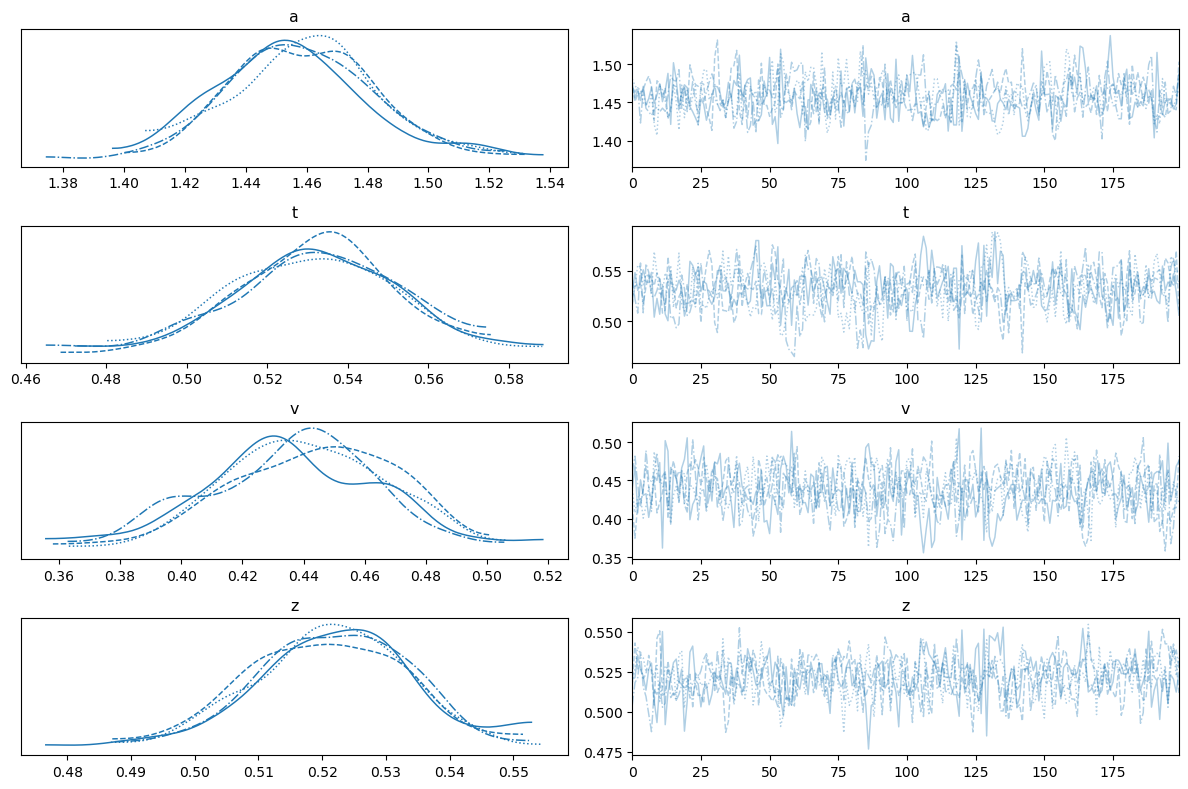

In [6]:
from hssm.distribution_utils import (
    make_distribution,
    make_likelihood_callable,
)

loglik_op = make_likelihood_callable(
    loglik="ddm.onnx",  # will be downloaded from huggingface
    loglik_kind="approx_differentiable",
    backend="jax",  # the onnx will be translated to JAX
    params_is_reg=[False] * 4,  # required if backend is JAX.
    # Since the model below has no regression, we provide a list of 4 `False`s
)

DDM_JAX = make_distribution(
    rv="ddm",
    loglik=loglik_op,
    list_params=["v", "a", "z", "t"],
    bounds={"t": (0, 2), "a": (0, 2.5)},
)

with pm.Model() as ddm_jax_model:
    v = pm.Uniform("v", lower=-3, upper=3)
    a = pm.Gamma("a", mu=0.5, sigma=1.0)
    z = pm.Uniform("z", lower=0.1, upper=0.9)
    t = pm.Uniform("t", lower=0.01, upper=1.0, initval=0.1)

    ddm = DDM_JAX("ddm", v=v, a=a, z=z, t=t, observed=dataset.values)

    ddm_jax_trace = pm.sample(mp_ctx="spawn", tune=500, draws=200)

az.plot_trace(ddm_jax_trace)
plt.tight_layout()